# Group Assignment (Group 15) — Big Data
### By Matteo Ballegeer, Yaël De Rocker, Wannes Janssens, Julian Peire, Tom Willemen
#### Ghent University, Belgium
### -------------------------------------------------------------------------------------------------------------------

# General Brand Comparison

In this notebook, we provide visuals in order to compare Lufthansa and Singapore, both in a general and strategic sense

## 1 Imports and cluster setup

In [1]:
import os
# Set the current working directory to the parent directory
os.chdir('..')

# spark imports
import findspark
import pyspark
import sys
import os
# specify user for hardware specifications
user="Matteo"

if user =="Tom":
    findspark.init("C:\Spark\spark-3.4.1-bin-hadoop3")
    config = pyspark.SparkConf().setAll([('spark.executor.memory', '8g'), 
                                        ('spark.executor.cores', '10'), 
                                        ('spark.cores.max', '8'), 
                                        ('spark.driver.memory','16g'),
                                        ('spark.network.timeout', '3600s'),
                                        ("spark.executor.heartbeatInterval", "3000s")])   # Increased the network timeout 

if user =="Matteo":
    findspark.init("C:\Spark\spark-3.5.0-bin-hadoop3")
    config = pyspark.SparkConf().setAll([
        ('spark.executor.memory', '8g'),
        ('spark.executor.cores', '4'),
        ('spark.cores.max', '4'),
        ("spark.sql.shuffle.partitions", "4"),
        ('spark.driver.memory', '8g'),
        ("spark.executor.instances", "4"),
        ('spark.network.timeout', '3600s'),
    ])
    config.setMaster("local[7]")

if user == "Julian":
    findspark.init('C:\\Users\\jaron\\Spark\\spark-3.5.0-bin-hadoop3')
    config = pyspark.SparkConf().setAll([('spark.executor.memory', '8g'), 
                                            ('spark.executor.cores', '8'), 
                                            ('spark.cores.max', '7'), 
                                            ('spark.driver.memory','16g'),
                                            ('spark.network.timeout', '3600s'),
                                            ("spark.executor.heartbeatInterval", "3000s")])   # Increased the network timeout
    config.setMaster("local[8]")    

if user == "Wannes":
    findspark.init("C:\Spark\spark-3.5.0-bin-hadoop3")
    config = pyspark.SparkConf().setAll([
        ("spark.executor.memory", "8g"),
        ("spark.executor.cores", "8"),
        ('spark.driver.memory', '8g'),
        ('spark.cores.max', '8')
    ]) 
    config.setMaster("local[4]")

if user == "Yaël":
    findspark.sql.SparkSession.builder.master("local[*]")
    config = findspark.SparkConf().setAll([
        ("spark.executor.memory", "7g"),
        ('spark.yarn.am.memory', '7g'),
        ('spark.yarn.am.cores', '8'),
        ("spark.executor.cores", "8"),
        ('spark.driver.memory', '7g'),
        ('spark.cores.max', '8')
    ])
    sys.path.append('/Users/derockeryael/Documents/Master 2/Big Data/big_data_group_15')
    config.setAppName("x").setMaster("local[8]")

# create spark session 
sc = pyspark.SparkContext(conf=config)  
spark = pyspark.sql.SparkSession(sc)

In [2]:
spark

In [3]:
# import packages
import os 
import json
import lzma
import seaborn as sns
from tqdm import tqdm
from langdetect import detect

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sn

import pyspark.sql.functions as F
from pyspark.sql.types import *

from pyspark.sql.functions import col, when, substring, rand

from wordcloud import WordCloud
from PIL import Image

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from string import punctuation
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Matteo_Ballegeer\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
# define data dir
data_dir_sin  = "./data/singaporeair/"
data_dir_luf  = "./data/lufthansa_usa/"
tagged_dir_sin  = "./data/singaporeair/%3Atagged/"
tagged_dir_luf  = "./data/lufthansa_usa/%3Atagged/"

Define functions and UDFs

In [5]:
# define puncutation (!, @, and #)
PUNCTUATION = [char for char in punctuation if char not in ["!", "@", "#"]]

# define english stopwords
STOPWORDS = stopwords.words("english")
# define a function to remove punctuation
def remove_punct(text):
    # remove punctuation from text
    text = "".join([char for char in text if char not in PUNCTUATION])
    return(text)
# define a function to remove stopwords
def remove_stops(text_tokenized):
    # remove stopwords from text
    text_tokenized = [word for word in text_tokenized if word not in STOPWORDS]
    return(text_tokenized)
# register functions as udf
remove_punct_UDF = F.udf(remove_punct, StringType())
remove_stops_UDF = F.udf(remove_stops, ArrayType(StringType()))
# define function to count hashtags
def get_hashtags(tokenized_text):
    # initialize counter
    counter = 0

    # loop over tokens
    for word in tokenized_text:
        # count the number of tokens that include the '#' character
        if "#" in word:
            # add 1 to counter
            counter += 1

    return counter
# register as udf
get_hashtags_udf = F.udf(get_hashtags, IntegerType())
# define function to count tags
def get_tags(tokenized_text):
    # initialize counter
    counter = 0

    # loop over tokens
    for word in tokenized_text:
        # count the number of tokens that include the '#' character
        if "@" in word:
            # add 1 to counter
            counter += 1

    return counter
# register as udf
get_tags_udf = F.udf(get_tags, IntegerType())

# define function to decompress xz file and save as .json
def decompress_xz_file(f_path):
    # define new name
    new_path = f_path.replace(".xz", "")

    # save decompressed file
    with open(new_path, "w") as f:
        json.dump(json.load(lzma.open(f_path)), f)

# Define function to tokenize text
def tokenize_text(text):
    return text.split(" ")

tokenize_text_UDF = F.udf(tokenize_text, ArrayType(StringType()))

## 2 Brand comparison

### 2.1. Loading in the data

In [6]:
# get all the names of the post info files
post_info_names_sin = [obs for obs in os.listdir(data_dir_sin) if "UTC.json.xz" in obs]
post_info_names_luf = [obs for obs in os.listdir(data_dir_luf) if "UTC.json.xz" in obs]

# get all the paths of the comment files
post_info_paths_sin = [os.path.join(data_dir_sin, obs) for obs in post_info_names_sin]
post_info_paths_luf = [os.path.join(data_dir_luf, obs) for obs in post_info_names_luf]

In [7]:
# Progress bar for post_info_paths_sin
for f in tqdm(post_info_paths_sin, desc='Processing SIN files', unit='file'):
    decompress_xz_file(f)

# Progress bar for post_info_paths_luf
for f in tqdm(post_info_paths_luf, desc='Processing LUF files', unit='file'):
    decompress_xz_file(f)

Processing LUF files: 100%|██████████| 1879/1879 [01:13<00:00, 25.56file/s]


In [8]:
# get all the paths of the decompressed comment files
post_info_paths_sin = [os.path.join(data_dir_sin, obs).replace(".xz", "") for obs in post_info_names_sin]
post_info_paths_luf = [os.path.join(data_dir_luf, obs).replace(".xz", "") for obs in post_info_names_luf]
# load decompressed post info files
info_df_sin = spark.read.json(post_info_paths_sin, multiLine=True)
info_df_luf = spark.read.json(post_info_paths_luf, multiLine=True)

In [9]:
# Singaporeair
# add file path as a new column
info_df_sin = info_df_sin.withColumn("file_path", F.input_file_name())
# extract post id from file path and add as new column
info_df_sin = info_df_sin.withColumn("post_id", F.regexp_extract(str=info_df_sin.file_path, pattern="(singaporeair/)(.*)(.json)", idx=2))
# drop file path column
info_df_sin = info_df_sin.drop("file_path")

# Lufthansa
# add file path as a new column
info_df_luf = info_df_luf.withColumn("file_path", F.input_file_name())
# extract post id from file path and add as new column
info_df_luf = info_df_luf.withColumn("post_id", F.regexp_extract(str=info_df_luf.file_path, pattern="(lufthansa_usa/)(.*)(.json)", idx=2))
# drop file path column
info_df_luf = info_df_luf.drop("file_path")

Extract all usefull features from the schema

In [10]:
sin_posts_info = info_df_sin.select(
    F.col("node.edge_media_preview_like.count").alias("number_of_likes"),
    F.col("node.edge_media_to_comment.count").alias("comment_count"),
    F.col("node.edge_media_to_caption.edges").getItem(0).getField("node").getField("text").alias("caption_text"),
    F.col("node.location.address_json").alias("address_json"),
    F.col("node.location").alias("location"),
    F.col("node.taken_at_timestamp").alias("timestamp"),
    F.get_json_object("node.location.address_json", "$.country_code").alias("country_code"),
    F.get_json_object("node.location.address_json", "$.city_name").alias("city_name"),
    F.get_json_object("node.location.address_json", "$.region_name").alias("region_name"),
    F.col("node.edge_media_to_tagged_user.edges").alias("tagged_users"),
    F.size("node.edge_media_to_tagged_user.edges").alias("tagged_users_count"),
    F.size(F.expr("filter(node.edge_media_to_tagged_user.edges, edge -> edge.node.user.is_verified = true)")).alias("verified_tagged_users_count"),
    F.col("node.taken_at_timestamp").alias("taken_at_timestamp"),
    F.when(F.size("node.edge_sidecar_to_children.edges") > 0, True).otherwise(False).alias("is_carousel"), 
    F.col("node.is_video").alias("is_video"),
    F.col("node.is_ad").alias("is_ad"),
    F.col("node.video_view_count").alias("video_view_count"),
    F.col("node.edge_sidecar_to_children.edges").alias("test"),
    F.col("node.video_duration").alias("video_duration"),  
    F.col("node.title").alias("title"),    
    F.col("post_id"), 
    substring(F.col("post_id"), 1, 10).alias("date")  # Extracts the first 10 characters as the date
)

# Extract data for Lufthansa USA
luf_posts_info = info_df_luf.select(
    F.col("node.edge_media_preview_like.count").alias("number_of_likes"),
    F.col("node.edge_media_to_comment.count").alias("comment_count"),
    F.col("node.edge_media_to_caption.edges").getItem(0).getField("node").getField("text").alias("caption_text"),
    F.col("node.location.address_json").alias("address_json"),
    F.col("node.location").alias("location"),
    F.col("node.taken_at_timestamp").alias("timestamp"),
    F.get_json_object("node.location.address_json", "$.country_code").alias("country_code"),
    F.get_json_object("node.location.address_json", "$.city_name").alias("city_name"),
    F.get_json_object("node.location.address_json", "$.region_name").alias("region_name"),
    F.col("node.edge_media_to_tagged_user.edges").alias("tagged_users"),
    F.size("node.edge_media_to_tagged_user.edges").alias("tagged_users_count"),
    F.size(F.expr("filter(node.edge_media_to_tagged_user.edges, edge -> edge.node.user.is_verified = true)")).alias("verified_tagged_users_count"),
    F.col("node.taken_at_timestamp").alias("taken_at_timestamp"),
    F.when(F.size("node.edge_sidecar_to_children.edges") > 0, True).otherwise(False).alias("is_carousel"), 
    F.col("node.is_video").alias("is_video"),
    F.col("node.is_ad").alias("is_ad"),
    F.col("node.video_view_count").alias("video_view_count"),
    F.col("node.video_duration").alias("video_duration"),
    F.col("node.title").alias("title"),    
    F.col("post_id"),
    substring(F.col("post_id"), 1, 10).alias("date")  # Extracts the first 10 characters as the date
)

sin_posts_info.cache()
luf_posts_info.cache()

DataFrame[number_of_likes: bigint, comment_count: bigint, caption_text: string, address_json: string, location: struct<address_json:string,has_public_page:boolean,id:string,name:string,slug:string>, timestamp: bigint, country_code: string, city_name: string, region_name: string, tagged_users: array<struct<node:struct<user:struct<full_name:string,id:string,is_verified:boolean,profile_pic_url:string,username:string>,x:double,y:double>>>, tagged_users_count: int, verified_tagged_users_count: int, taken_at_timestamp: bigint, is_carousel: boolean, is_video: boolean, is_ad: boolean, video_view_count: bigint, video_duration: double, title: string, post_id: string, date: string]

### 2.2. Feature transformations & creation

#### Load in scraped followers over time & interpolate

In [ ]:
followers_luf = pd.read_csv("../additional_data/lufthansa_follower_history.csv")
print(followers_luf)

followers_sin = pd.read_csv("../additional_data/singaporeair_follower_history.csv")
print(followers_sin)

                 date  num_followers
0        01 June 2013              0
1      27 August 2013           4800
2     03 October 2014          48600
3     20 January 2015          80800
4     22 January 2015          81400
..                ...            ...
95  01 September 2020        1419921
96    01 October 2020        1416025
97   01 November 2020        1413994
98   01 December 2020        1414535
99    01 January 2021        1414143

[100 rows x 2 columns]
                 date  num_followers
0         01 May 2014              0
1      08 August 2014           2191
2     11 October 2014          20039
3         22 May 2015          62200
4     24 January 2016         211276
5       19 March 2016         270707
6    01 December 2016         474646
7    07 December 2016         478000
8    15 December 2016         482000
9    20 December 2016         485000
10  14 September 2018         898000
11   01 November 2018         965009
12   01 December 2018        1017758
13    01 Janua

In [ ]:
def interpolate_followers(df):
    # Convert 'DATE' column to datetime
    df['date'] = pd.to_datetime(df['date'], format='%d %B %Y')

    # Create a new DataFrame with daily dates between the first and last dates in your data
    daily_dates = pd.date_range(df['date'].min(), df['date'].max(), freq='D')
    daily_df = pd.DataFrame({'date': daily_dates})

    # Merge the original data with the daily dates DataFrame
    merged_df = pd.merge(daily_df, df, on='date', how='left')

    # Interpolate the missing values in the 'num_followers' column
    merged_df['num_followers'] = merged_df['num_followers'].interpolate().round().astype(int)

    return merged_df

# Process 'followers_luf'
followers_luf_interpolated = interpolate_followers(followers_luf)

# Process 'followers_sin'
followers_sin_interpolated = interpolate_followers(followers_sin)

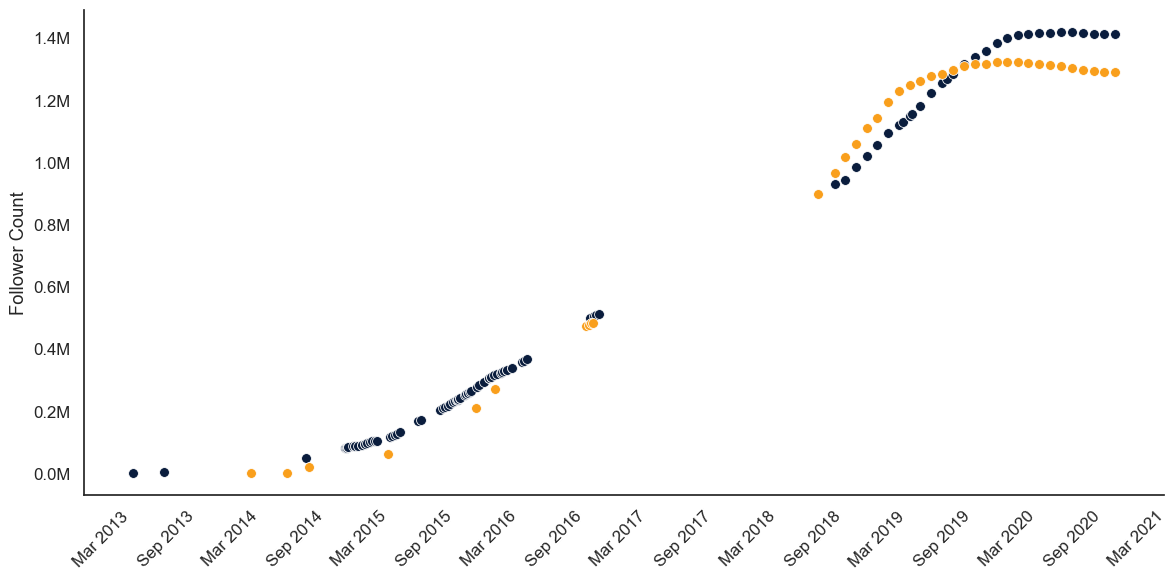

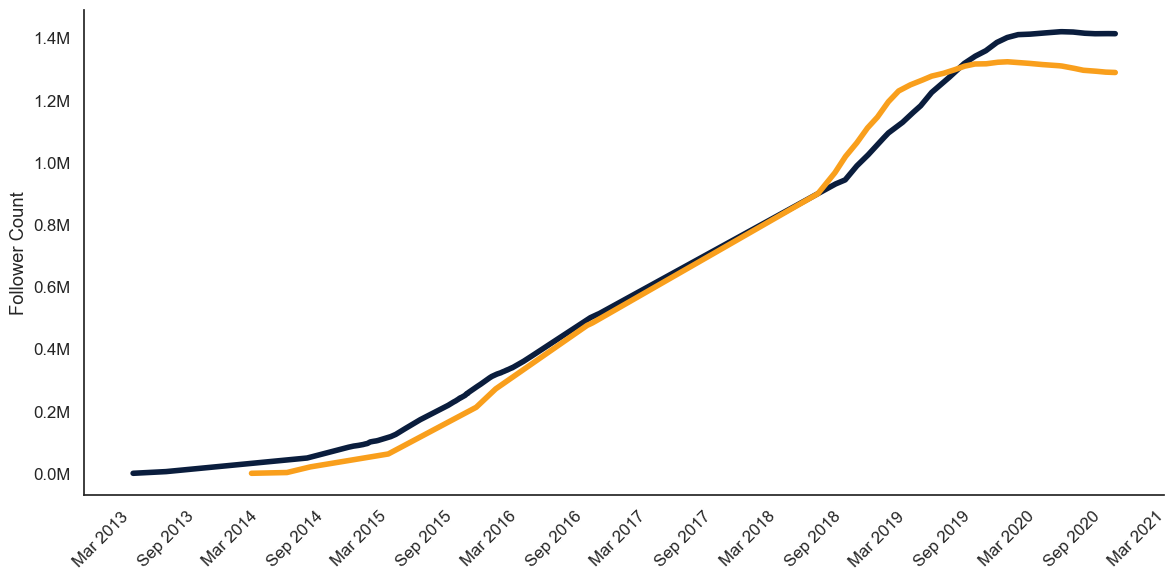

In [ ]:
# Set the color codes
sin_color = '#F99F1C'
luf_color = '#0A1D3D'

# Set Seaborn style with no X-axis grid lines
sns.set(style="white", palette="muted", font_scale=1.1)

# Create a function for plotting to avoid repetition
def plot_followers(ax, data, title = "", color="b", is_interpolated=False):
    if is_interpolated:
        sns.lineplot(x=data['date'], y=data['num_followers'], linewidth=4, color=color, ax=ax)
    else:
        sns.scatterplot(x=data['date'], y=data['num_followers'], color=color, s=50, ax=ax)
    ax.set_title(title)
    ax.set_xlabel('')
    ax.set_ylabel('Follower Count')
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,.1f}M".format(x/1000000)))
    ax.tick_params(axis='x', rotation=45)  # Rotate X-axis labels
    sns.despine()

# Plotting original data for both companies on the same plot
plt.figure(figsize=(12, 6))

# Plotting original data for followers_luf
plot_followers(plt.gca(), followers_luf, 'Follower Count Over Time', luf_color)

# Plotting original data for followers_sin on the same axis
plot_followers(plt.gca(), followers_sin, '', sin_color)

plt.title('')
plt.xlabel('')
plt.ylabel('Follower Count')

plt.tight_layout()
plt.show()

# Plotting interpolated data for both companies on the same plot
plt.figure(figsize=(12, 6))

# Plotting interpolated data for followers_luf
plot_followers(plt.gca(), followers_luf_interpolated, color = luf_color, is_interpolated=True)

# Plotting interpolated data for followers_sin on the same axis
plot_followers(plt.gca(), followers_sin_interpolated, color = sin_color, is_interpolated=True)

plt.title('')
plt.xlabel('')
plt.ylabel('Follower Count')

plt.tight_layout()
plt.show()

In [ ]:
# write to csv 
followers_sin_interpolated.to_csv("../additional_data/singapore_follower_interpolation.csv", index=False)

# write to csv 
followers_luf_interpolated.to_csv("../additional_data/lufthansa_follower_interpolation.csv", index=False)

#### Continued

In [11]:
# Read in followers data 
followers_luf = pd.read_csv("./additional_data/lufthansa_follower_interpolation.csv")
followers_sin = pd.read_csv("./additional_data/singaporeair_follower_interpolation.csv")

# Convert followers df to spark df
followers_luf_spark = spark.createDataFrame(followers_luf)
followers_sin_spark = spark.createDataFrame(followers_sin)

# Merge on date to get num_followers for each row
luf_posts_info = luf_posts_info.join(
    followers_luf_spark,
    on="date",
    how="left_outer"
)
sin_posts_info = sin_posts_info.join(
    followers_sin_spark,
    on="date",
    how="left_outer"
)
# Few weird posts with a date before the creation of the lufthansa account, drop them
luf_posts_info = luf_posts_info.dropna(subset=["num_followers"])

luf_posts_info.select("post_id","date","num_followers").orderBy(rand()).show(10)

+--------------------+----------+-------------+
|             post_id|      date|num_followers|
+--------------------+----------+-------------+
|2019-04-29_15-00-...|2019-04-29|      1117658|
|2016-05-03_19-38-...|2016-05-03|       338462|
|2018-06-04_13-29-...|2018-06-04|       835429|
|2014-02-14_14-45-...|2014-02-14|        23431|
|2014-07-14_13-35-...|2014-07-14|        39775|
|2017-07-24_15-31-...|2017-07-24|       638215|
|2017-04-21_18-04-...|2017-04-21|       579364|
|2018-04-30_00-46-...|2018-04-30|       813517|
|2014-07-08_14-15-...|2014-07-08|        39121|
|2015-08-29_19-30-...|2015-08-29|       177655|
+--------------------+----------+-------------+
only showing top 10 rows



Sometimes posts with no tags are NULL instead of a zero-length array, resulting in -1 as value for "tagged_users_count", let's set these to 0

In [12]:
print(luf_posts_info.select("post_id","number_of_likes","tagged_users","tagged_users_count","verified_tagged_users_count").orderBy("tagged_users_count").show(5))

luf_posts_info = luf_posts_info.withColumn("tagged_users_count", when(col("tagged_users_count") == -1, 0).otherwise(col("tagged_users_count")))
sin_posts_info = sin_posts_info.withColumn("tagged_users_count", when(col("tagged_users_count") == -1, 0).otherwise(col("tagged_users_count")))
luf_posts_info = luf_posts_info.withColumn("verified_tagged_users_count", when(col("verified_tagged_users_count") == -1, 0).otherwise(col("verified_tagged_users_count")))
sin_posts_info = sin_posts_info.withColumn("verified_tagged_users_count", when(col("verified_tagged_users_count") == -1, 0).otherwise(col("verified_tagged_users_count")))

print(luf_posts_info.select("post_id","number_of_likes","tagged_users","tagged_users_count","verified_tagged_users_count").orderBy("tagged_users_count").show(5))

+--------------------+---------------+------------+------------------+---------------------------+
|             post_id|number_of_likes|tagged_users|tagged_users_count|verified_tagged_users_count|
+--------------------+---------------+------------+------------------+---------------------------+
|2013-11-15_00-26-...|            133|        NULL|                -1|                         -1|
|2017-10-30_17-19-...|            924|        NULL|                -1|                         -1|
|2015-09-05_17-25-...|            311|        NULL|                -1|                         -1|
|2018-05-20_22-09-...|           1244|        NULL|                -1|                         -1|
|2014-08-28_14-34-...|            397|        NULL|                -1|                         -1|
+--------------------+---------------+------------+------------------+---------------------------+
only showing top 5 rows

None
+--------------------+---------------+------------+------------------+---------

In [13]:
# Convert Spark DataFrames to Pandas DataFrames for plotting
sin_posts_pd = sin_posts_info.toPandas()
luf_posts_pd = luf_posts_info.toPandas()
sin_color = '#F99F1C'
luf_color = '#0A1D3D'

In [14]:
# Make correct temporal features from post_id to plot
sin_posts_pd["post_id"] = pd.to_datetime(sin_posts_pd["post_id"], format="%Y-%m-%d_%H-%M-%S_UTC")
sin_posts_pd["year_month"] = sin_posts_pd["post_id"].dt.to_period('M')
sin_posts_pd["day_hour"] = sin_posts_pd["post_id"].dt.strftime('%A - %H')
sin_posts_pd["time_of_day"] = sin_posts_pd["post_id"].dt.hour

luf_posts_pd["post_id"] = pd.to_datetime(luf_posts_pd["post_id"], format="%Y-%m-%d_%H-%M-%S_UTC")
luf_posts_pd["year_month"] = luf_posts_pd["post_id"].dt.to_period('M')
luf_posts_pd["time_of_day"] = luf_posts_pd["post_id"].dt.hour
luf_posts_pd["day_hour"] = luf_posts_pd["post_id"].dt.strftime('%A - %H')

# Combine the data for both airlines so that we can use the same bins easily
combined_data = pd.concat([sin_posts_pd, luf_posts_pd])

In [15]:
# Add engagement column
sin_posts_pd["engagement"] = (sin_posts_pd["number_of_likes"] + sin_posts_pd["comment_count"]) / sin_posts_pd["num_followers"] * 100
luf_posts_pd["engagement"] = (luf_posts_pd["number_of_likes"] + luf_posts_pd["comment_count"]) / luf_posts_pd["num_followers"] * 100

Create the dataframes with temporal cut-off in September 2019 (when both companies reached 500k+ followers & strategies are considered more robust)

**Note that this one will be used in most of our calculations, except for some plots showing trends**

In [16]:
sin_posts_mature = sin_posts_pd[sin_posts_pd['year_month'] >= '2016-09']
luf_posts_mature = luf_posts_pd[luf_posts_pd['year_month'] >= '2016-09']

## 3 Visualization

### 3.1. General post information

In [53]:
# Get the number of posts for each company
print(f"Number of posts made by Lufthansa USA: {len(sin_posts_pd)}")
print(f"Number of posts made by SingaporeAir: {len(luf_posts_pd)}")

Number of posts made by Lufthansa USA: 1785
Number of posts made by SingaporeAir: 1863


Number of (influencer) tags

In [56]:
sin_tags = len(sin_posts_pd[sin_posts_pd['tagged_users_count'] != 0])/len(sin_posts_pd)
sin_tags_infl = sum(sin_posts_pd['verified_tagged_users_count'])/sum(sin_posts_pd['tagged_users_count'])
luf_tags = len(sin_posts_pd[luf_posts_pd['tagged_users_count'] != 0])/len(luf_posts_pd)
luf_tags_infl = sum(luf_posts_pd['verified_tagged_users_count'])/sum(luf_posts_pd['tagged_users_count'])

print(f"SingaporeAir percentage of posts with 1 or more tags: {sin_tags:.2%}")
print(f"SingaporeAir percentage of posts with tags having influencer tags: {sin_tags_infl:.2%}")
print(f"Lufthansa USA percentage of posts with 1 or more tags: {luf_tags:.2%}")
print(f"Lufthansa USA percentage of posts with tags having influencer tags: {luf_tags_infl:.2%}")

SingaporeAir percentage of posts with 1 or more tags: 0.62%
SingaporeAir percentage of posts with tags having influencer tags: 25.00%
Lufthansa USA percentage of posts with 1 or more tags: 6.44%
Lufthansa USA percentage of posts with tags having influencer tags: 18.35%


C:\Users\Matteo_Ballegeer\AppData\Local\Temp\ipykernel_3196\929705979.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  luf_tags = len(sin_posts_pd[luf_posts_pd['tagged_users_count'] != 0])/len(luf_posts_pd)


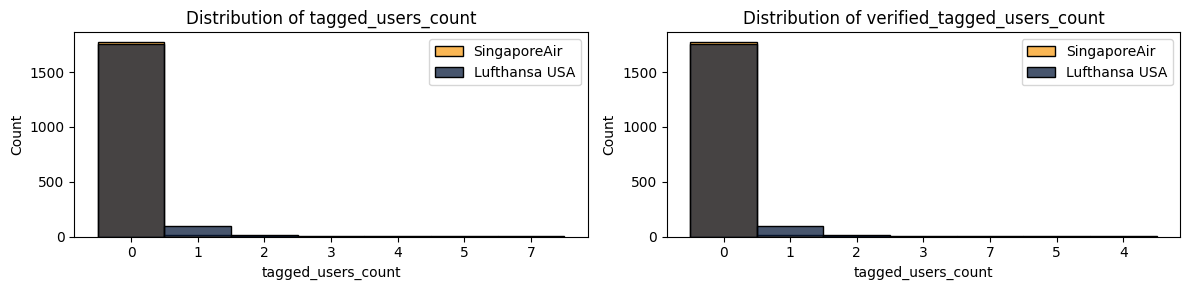

In [27]:
# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 3))

# Plot histograms for 'tagged_users_count' on the first subplot
sns.histplot(sin_posts_pd.sort_values('tagged_users_count')['tagged_users_count'].astype(str), label='SingaporeAir', bins=7, ax=axs[0],color = sin_color)
sns.histplot(luf_posts_pd.sort_values('tagged_users_count')['tagged_users_count'].astype(str), label='Lufthansa USA', bins=7, ax=axs[0],color = luf_color)
axs[0].set_title('Distribution of tagged_users_count')
axs[0].legend()

# Plot histograms for 'verified_tagged_users_count' on the second subplot
sns.histplot(sin_posts_pd.sort_values('verified_tagged_users_count')['tagged_users_count'].astype(str), label='SingaporeAir', bins=7, ax=axs[1],color = sin_color)
sns.histplot(luf_posts_pd.sort_values('verified_tagged_users_count')['tagged_users_count'].astype(str), label='Lufthansa USA', bins=7, ax=axs[1],color = luf_color)
axs[1].set_title('Distribution of verified_tagged_users_count')
axs[1].legend()

# Adjust layout
plt.tight_layout()
plt.show()

Main observations: 
- Neither of the two companies seem to be utilizing tags all that often, with SingaporeAir using them considerably less than Lufthansa
- When they do utilize tags, both tag a comparable fraction of influencers

Let's tag a look at location tags

In [ ]:
print("Main SingaporeAir post locations:")
print(sin_posts_pd['country_code'].value_counts())

print("\nMain Lufthansa post locations:")
print(luf_posts_pd['country_code'].value_counts())

Main SingaporeAir post locations:
SG    26
DK     1
CN     1
Name: country_code, dtype: int64

Main Lufthansa post locations:
DE    159
US     68
GB     60
       48
RU     44
NP     38
ES     36
FR     33
PT     31
IT     30
SE     27
GR     14
HR     13
HU     13
CZ     12
FI     11
CH     10
BG      9
TH      9
AT      8
PL      8
MT      7
AZ      5
IS      5
CN      5
ZA      5
NL      5
IE      4
IN      4
NO      3
DK      2
MC      1
BE      1
JP      1
TR      1
SM      1
CD      1
EG      1
IL      1
Name: country_code, dtype: int64


Calculate percentages (note, 500k+ followers' data only)

In [ ]:
print(f"Percentage of location tagged posts for Singapore Air: {sum(sin_posts_mature['country_code'].value_counts())/len(sin_posts_mature)}")
print(f"Percentage of location tagged posts for Lufthansa: {sum(luf_posts_mature['country_code'].value_counts())/len(luf_posts_mature)}")

print(f"Of which in Singapore: {sum(sin_posts_mature['country_code'] == 'SG') / sum(sin_posts_mature['country_code'].value_counts())}")
print(f"Of which in Germany: {sum(luf_posts_mature['country_code'] == 'DE')/sum(luf_posts_mature['country_code'].value_counts())}")

Percentage of location tagged posts for Singapore Air: 0.01568627450980392
Percentage of location tagged posts for Lufthansa: 0.39398819108964034
Of which in Singapore: 0.9285714285714286
Of which in Germany: 0.21662125340599456


### 3.2. Comparison over time

Group the data by month and plot engagement

In [19]:
# Grouping by 'year_month' and 'time_of_day' for both companies
sin_grouped_month = sin_posts_pd.groupby('year_month').size().reset_index(name='count')
luf_grouped_month = luf_posts_pd.groupby('year_month').size().astype(int).reset_index(name='count')
combined_month = pd.merge(sin_grouped_month, luf_grouped_month, on='year_month', how='outer', suffixes=('_sin', '_luf'))
combined_month['year_month'] = combined_month['year_month'].astype(str)
combined_month = combined_month.sort_values("year_month")
combined_month = combined_month.fillna(0)

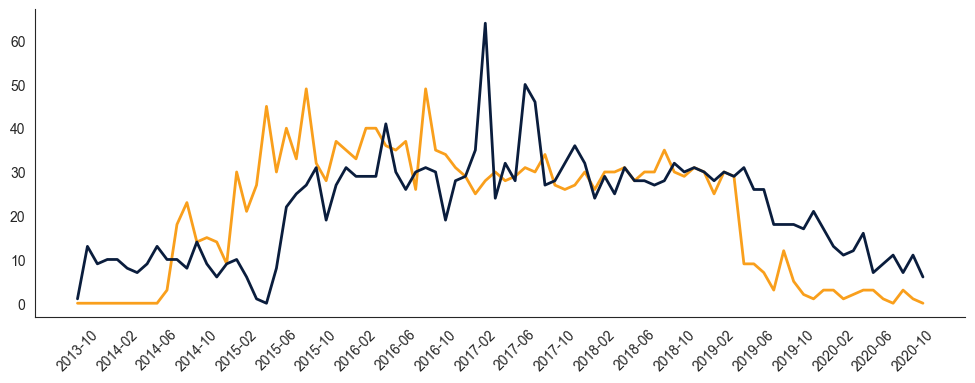

In [20]:
sns.set_style("white")
# Plot the combined data
fig, axs = plt.subplots(figsize=(12, 4))

# Plot lines for each metric
sns.lineplot(x='year_month', y='count_sin', data=combined_month, label='Singapore Air',linewidth = 2, ax=axs,color = sin_color)
sns.lineplot(x='year_month', y='count_luf', data=combined_month, label='Lufthansa USA',linewidth = 2, ax=axs,color = luf_color)
axs.set_title('')
axs.set_xticks(range(0, len(combined_month['year_month']), 4))
axs.set_xticklabels(combined_month['year_month'][::4], rotation=45)
axs.legend().set_visible(False)
sns.despine()
plt.xlabel("")
plt.ylabel("")
plt.show()

Is this decline in post frequency affecting engagement? 

We define engagement as **num likes + num comments / num followers at post time**

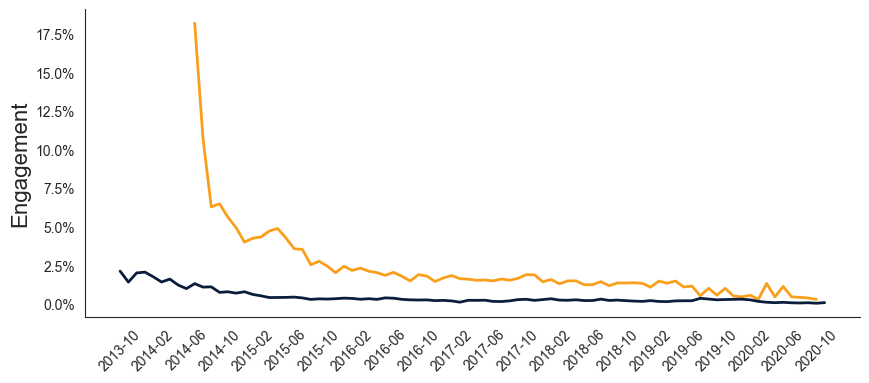

In [21]:
# Grouping by 'year_month' and 'time_of_day' for both companies
sin_engagement = sin_posts_pd.groupby('year_month')['engagement'].mean().reset_index(name='engagement')
luf_engagement = luf_posts_pd.groupby('year_month')['engagement'].mean().reset_index(name='engagement')
grouped_engagement = pd.merge(sin_engagement, luf_engagement, on='year_month', how='outer', suffixes=('_sin', '_luf'))
grouped_engagement['year_month'] = grouped_engagement['year_month'].astype(str)
grouped_engagement = grouped_engagement.sort_values("year_month")

# Plot both on the same axis
fig, axs = plt.subplots(figsize=(10, 4))
sns.lineplot(x='year_month', y='engagement_sin', data=grouped_engagement, linewidth=2, ax=axs, color=sin_color, label='SingaporeAir')
sns.lineplot(x='year_month', y='engagement_luf', data=grouped_engagement, linewidth=2, ax=axs, color=luf_color, label='Luf Company')

axs.set_title('')
axs.set_xticks(range(0, len(grouped_engagement['year_month']), 4))
axs.set_xticklabels(grouped_engagement['year_month'][::4], rotation=45)
axs.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,.1f}%".format(x)))
sns.despine()
axs.set_xlabel("")
axs.set_ylabel("Engagement",fontsize=16)
axs.legend().set_visible(False)

plt.show()

Let's only consider only from september 2016 onwards (500k+ followers), as engagement is expected to be very high when the number of followers are still small

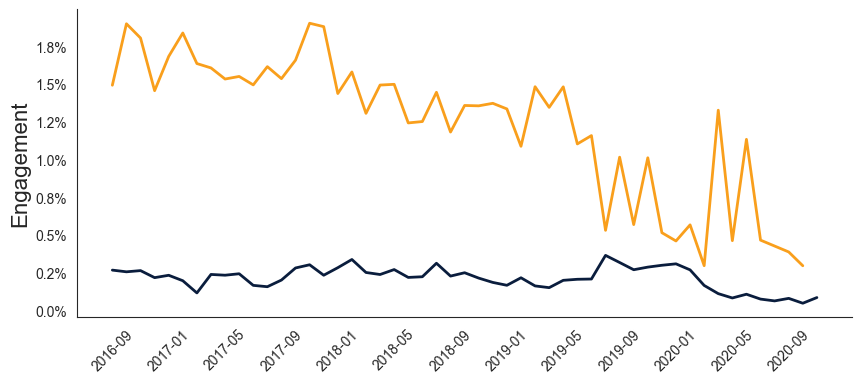

In [23]:
# Filter data from September 2016 onwards
grouped_engagement_filtered = grouped_engagement[grouped_engagement['year_month'] >= '2016-09']

# Plot both on the same axis
fig, axs = plt.subplots(figsize=(10, 4))
sns.lineplot(x='year_month', y='engagement_sin', data=grouped_engagement_filtered, linewidth=2, ax=axs, color=sin_color, label='SingaporeAir')
sns.lineplot(x='year_month', y='engagement_luf', data=grouped_engagement_filtered, linewidth=2, ax=axs, color=luf_color, label='Luf Company')

axs.set_title('')
axs.set_xticks(range(0, len(grouped_engagement_filtered['year_month']), 4))
axs.set_xticklabels(grouped_engagement_filtered['year_month'][::4], rotation=45)
axs.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,.1f}%".format(x)))
sns.despine()
axs.set_xlabel("")
axs.set_ylabel("Engagement",fontsize=16)
axs.legend().set_visible(False)

plt.show()

Let's calculate the average engagement in 2020 to compare to our benchmarks

In [27]:
# Filter rows for the year 2020
eng_2020 = grouped_engagement_filtered[(grouped_engagement_filtered['year_month'] >= '2020-01') & (grouped_engagement_filtered['year_month'] <= '2020-12')]

# Calculate the average for the 'engagement_luf' column
average_luf_2020 = eng_2020['engagement_luf'].mean()
average_sin_2020 = eng_2020['engagement_sin'].mean()

print(f"The average engagement for Lufthansa in 2020 is: {average_luf_2020}")
print(f"The average engagement for SingaporeAir in 2020 is: {average_sin_2020}")

The average engagement for Lufthansa in 2020 is: 0.1269439083829207
The average engagement for SingaporeAir in 2020 is: 0.5995698065591237


### 3.3. Post timing

In [20]:
# get metrics per hour per day
post_per_dayhour_sin = sin_posts_mature.groupby('day_hour').size().reset_index(name='count')
post_per_dayhour_luf = luf_posts_mature.groupby('day_hour').size().reset_index(name='count')

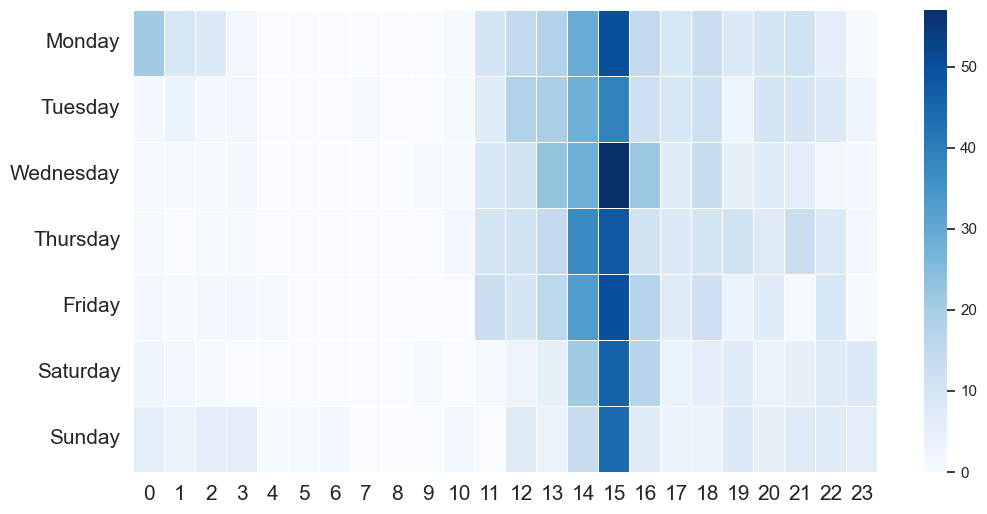

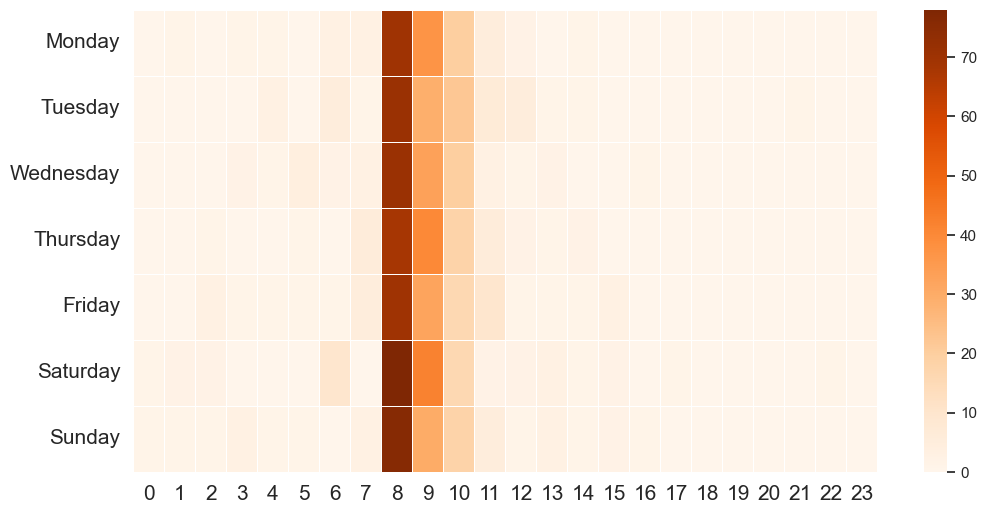

In [25]:
# define plotting function
sns.set_theme(style="white")
def create_heatmap(grouped_data, title, cmap="Blues", hours_to_add=0):
    # Extract day and hour from the 'day_hour' column
    grouped_data['day'] = grouped_data['day_hour'].apply(lambda x: x.split(' - ')[0])
    grouped_data['hour'] = grouped_data['day_hour'].apply(lambda x: (int(x.split(' - ')[1].split(':')[0]) + hours_to_add) % 24)
    # Include also combinations that do not occur (for plotting)
    all_days = grouped_data['day'].unique()
    all_hours = range(24)
    complete_data = [(day, hour) for day in all_days for hour in all_hours]
    complete_df = pd.DataFrame(complete_data, columns=['day', 'hour'])
    # Merge with existing data, filling NaN values with 0
    merged_data = pd.merge(complete_df, grouped_data, on=['day', 'hour'], how='left').fillna(0)
    # Pivot the DataFrame & specify correct order (days)
    heatmap_data = merged_data.pivot(index='day', columns='hour', values='count')
    day_order = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
    heatmap_data = heatmap_data.reindex(day_order)
    # Create a heatmap with fixed x-axis width
    plt.figure(figsize=(12, 6))
    sns.heatmap(heatmap_data, cmap=cmap, annot=False, linewidths=.5)
    plt.title(title)
    plt.yticks(rotation = 0,fontsize = 15)
    plt.xticks(fontsize = 15)
    plt.ylabel("")
    plt.xlabel("")
    plt.show()

create_heatmap(post_per_dayhour_luf, '',cmap="Blues")
create_heatmap(post_per_dayhour_sin, '',cmap="Oranges")

For time of day, we should be careful in our conclusions as all post times are UTC. Let's adjust these to local time:
- Germany for Lufthansa
- Singapore for Singapore Air

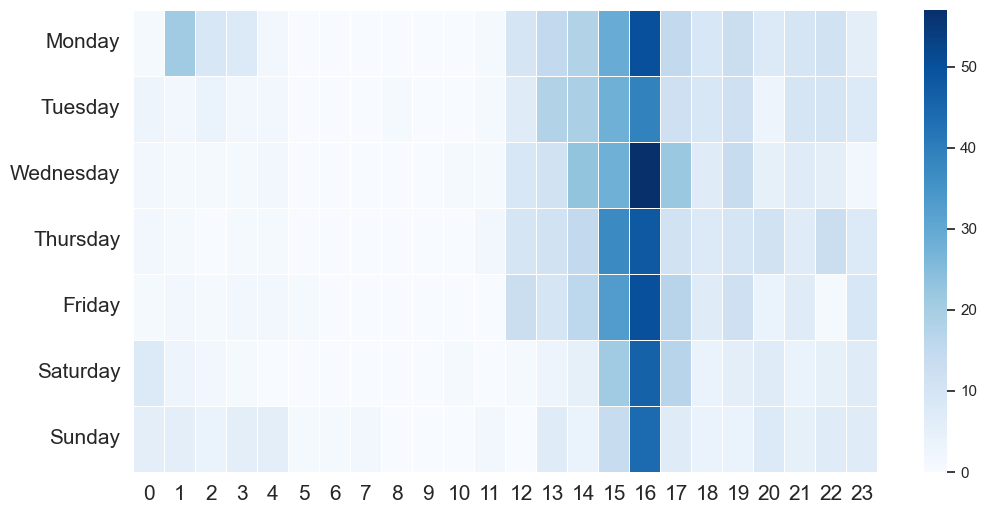

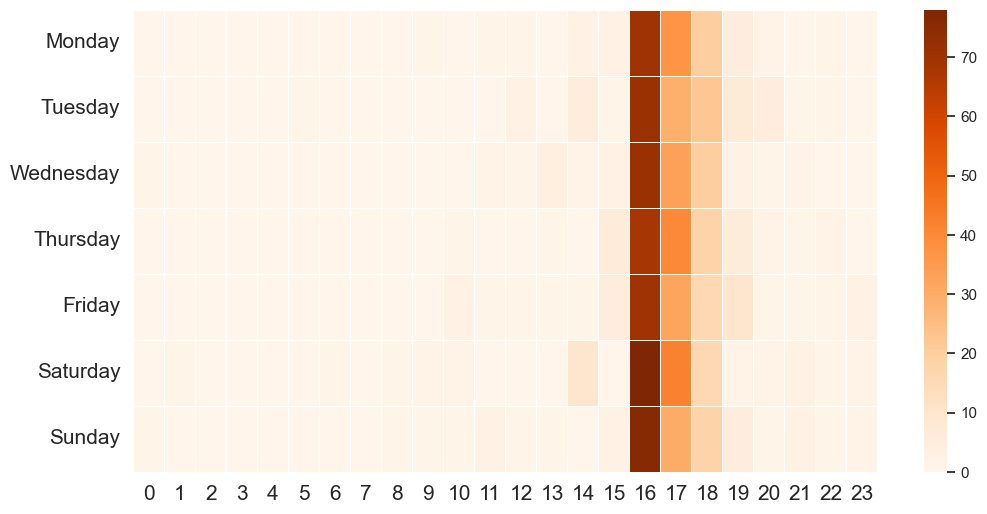

In [31]:
create_heatmap(post_per_dayhour_luf, '',hours_to_add = 1)
create_heatmap(post_per_dayhour_sin, '',hours_to_add = 8,cmap = "Oranges")

**Further research**: would be very nice to have info on the country of residence of our followers (we don't), because that way we could adjust the timing of posts according to our main group of followers. For now, not a customer-centric approach but will just take Singapore and Germany as reference for posting time

Conclusion:
- Both companies focus on the late afternoon
- SingaporeAir is slightly more strict in this than Lufthansa
- Singapore posts more in weekends, Lufthansa more in mid-week

### 3.4 Caption analysis

#### 3.4.1. Top hashtags

In [ ]:
# calculate how many posts have a hashtag
def calculate_percentage(df, name):
    rows_with_hash_count = df.filter(col("text").contains("#")).count()
    total_rows = df.count()
    percentage_with_hash = (rows_with_hash_count / total_rows) * 100

    print(f"{name}:")
    print(f"Number of rows with '#' in 'text': {rows_with_hash_count}")
    print(f"Total number of rows: {total_rows}")
    print(f"Percentage of rows with '#': {percentage_with_hash:.2f}%")
    print("\n")

# Calculate and print results for both DataFrames
calculate_percentage(luf_posts_mature, "basetable_luf")
calculate_percentage(sin_posts_mature, "basetable_sin")

basetable_luf:
Number of rows with '#' in 'text': 716
Total number of rows: 1232
Percentage of rows with '#': 58.12%


basetable_sin:
Number of rows with '#' in 'text': 964
Total number of rows: 1034
Percentage of rows with '#': 93.23%




In [ ]:
from pyspark.sql.functions import explode, split, col, lower, regexp_replace, regexp_extract

def process_hashtags(df):
    # Remove newline characters and convert text to lowercase
    df_cleaned = df.withColumn("text", lower(regexp_replace(regexp_replace(regexp_replace("text", "\n", " "), "\r", " "),"#"," #")))

    # Remove punctuations, except hashtags
    df_cleaned = df_cleaned.withColumn("text", regexp_replace("text", "(?!#)[^a-zA-Z0-9\\s]", ""))

    # Split the cleaned text into words
    df_words = df_cleaned.select("post_id", explode(split("text", " ")).alias("word"))

    # Filter rows that start with "#"
    words_with_hashtag = df_words.filter(col("word").startswith("#"))

    # Group by the hashtag words and count their occurrences
    words_with_hashtag_counts = words_with_hashtag.groupBy("word").count()

    # Order by count in descending order
    words_with_hashtag_counts = words_with_hashtag_counts.orderBy("count", ascending=False)

    return words_with_hashtag_counts

# Process basetable_luf
words_with_hashtag_luf = process_hashtags(luf_posts_mature)

# Process basetable_sin
words_with_hashtag_sin = process_hashtags(sin_posts_mature)

# Show the results for Lufthansa
print("Lufthansa Hashtag Counts:")
words_with_hashtag_luf.show(truncate=False)

# Show the results for Singapore Airlines
print("Singapore Airlines Hashtag Counts:")
words_with_hashtag_sin.show(truncate=False)

Lufthansa Hashtag Counts:
+--------------------+-----+
|word                |count|
+--------------------+-----+
|#lhcityofthemonth   |183  |
|#cityofthemonth     |84   |
|#inspiredby         |78   |
|#heimweh            |77   |
|#lufthansa          |45   |
|#wingwednesday      |27   |
|#sayyestotheworld   |22   |
|#munich             |19   |
|#happytoseeyouagain |13   |
|#lisbon             |12   |
|#wecare             |12   |
|#windowviews        |11   |
|#avgeek             |10   |
|#sofia              |10   |
|#weareinthistogether|10   |
|#lhfashionflight    |9    |
|#krakow             |9    |
|#bangkok            |9    |
|#contest            |9    |
|#wingviews          |8    |
+--------------------+-----+
only showing top 20 rows

Singapore Airlines Hashtag Counts:
+-----------------------+-----+
|word                   |count|
+-----------------------+-----+
|#flysq                 |905  |
|#singaporeair          |845  |
|#sqfoodie              |186  |
|#sqavgeek              |

#### 3.4.2. Word cloud

In [ ]:
def clean_text_data(df):
    # Define regular expressions
    remove_hashtags_urls_regex = "(#\\w+\\s*)|((http|https)://\S+\s*)|(www\.\S+\s*)"
    punctuation_regex = "[\W_]"
    remove_rn_regex = "[\r\n]"
    remove_single_characters_regex = "\\b\\w\\b"

    # Apply transformations to clean the text
    cleaned_df = df.withColumn("text", regexp_replace(col("text"), remove_hashtags_urls_regex, ""))
    cleaned_df = cleaned_df.withColumn("text", regexp_replace(col("text"), punctuation_regex, " "))
    cleaned_df = cleaned_df.withColumn("text", regexp_replace(col("text"), remove_rn_regex, ""))
    cleaned_df = cleaned_df.withColumn("text", lower(col("text")))
    cleaned_df = cleaned_df.withColumn("text", regexp_replace(col("text"), remove_single_characters_regex, ""))

    # Additional transformations
    cleaned_df = cleaned_df \
        .withColumn("text_tokenized", tokenize_text_UDF("text")) \
        .withColumn("text_tokenized", remove_stops_UDF("text_tokenized")) \
        .withColumn("text_tokenized", F.expr("filter(text_tokenized, x -> x != '')"))
    return cleaned_df

luf_text_cleaned = clean_text_data(luf_posts_mature)
luf_text_cleaned.cache()
sin_text_cleaned = clean_text_data(sin_posts_mature)
sin_text_cleaned.cache()
luf_text_cleaned.select("text_tokenized").show(3,truncate=False)
sin_text_cleaned.select("text_tokenized").show(3,truncate=False)

+-----------------------------------------------------------------------------------------------------+
|text_tokenized                                                                                       |
+-----------------------------------------------------------------------------------------------------+
|[happy, september, summer, coming, close, last, minute, vacations, planned, photo, pinkflamingodiary]|
|[discover, peaceful, spot, germany, photo, joewestwoood]                                             |
|[inflight, magazine, want, read, cover, cover, photo, marshall, berlin]                              |
+-----------------------------------------------------------------------------------------------------+
only showing top 3 rows

+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|text_tokenized               

In [ ]:
def generate_word_frequencies(df):
    # Explode the list of tokens into separate rows
    exploded_df = df.select(explode("text_tokenized").alias("word"))

    # Group by the word and count its occurrences
    word_frequencies = exploded_df.groupBy("word").count()

    # Order by count in descending order
    word_frequencies = word_frequencies.orderBy("count", ascending=False)

    return word_frequencies

# Generate word frequencies for Lufthansa
luf_word_frequencies = generate_word_frequencies(luf_text_cleaned)

# Generate word frequencies for Singapore Airlines
sin_word_frequencies = generate_word_frequencies(sin_text_cleaned)

# Display the results
print("Word Frequencies for Lufthansa:")
luf_word_frequencies.show(10,truncate=False)
print("\nWord Frequencies for Singapore Airlines:")
sin_word_frequencies.show(10,truncate=False)

Word Frequencies for Lufthansa:
+------+-----+
|word  |count|
+------+-----+
|photo |676  |
|time  |92   |
|us    |89   |
|home  |85   |
|city  |82   |
|travel|79   |
|see   |75   |
|berlin|70   |
|one   |68   |
|take  |55   |
+------+-----+
only showing top 10 rows


Word Frequencies for Singapore Airlines:
+---------+-----+
|word     |count|
+---------+-----+
|us       |144  |
|singapore|129  |
|share    |75   |
|next     |65   |
|book     |64   |
|favourite|57   |
|flight   |57   |
|view     |54   |
|aircraft |52   |
|city     |51   |
+---------+-----+
only showing top 10 rows



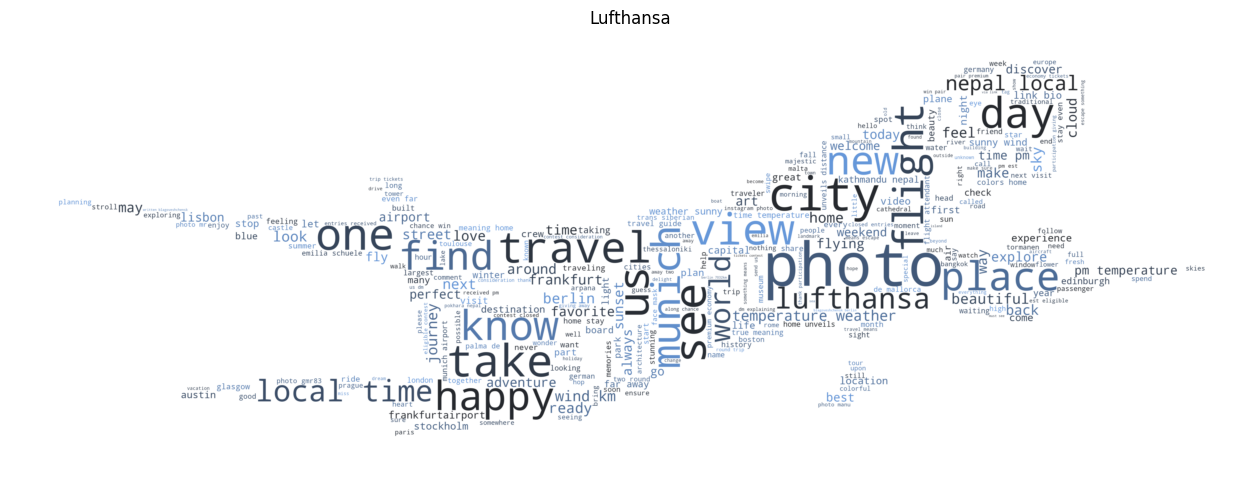

In [ ]:
def generate_word_cloud(tokens_column, airline_name, mask_path, max_words=100, colormap='viridis',stopwords=None,relative_scaling = 0.5):
    # Flatten the list of lists
    all_tokens = [str(word) for tokens_list in tokens_column for word in tokens_list]

    # Combine the words into a single string
    text_combined = " ".join(all_tokens)
    text_combined = text_combined.replace("'", "")

    # Load the airplane-shaped mask image
    mask = np.array(Image.open(mask_path))

    # Generate the word cloud using the mask and specify a color theme
    wordcloud = WordCloud(width=600, height=400, background_color="white", max_words=max_words,
                          mask=mask, contour_width=1, contour_color='white', collocations=True,stopwords=stopwords,
                          colormap=colormap, relative_scaling = relative_scaling).generate(text_combined)

    # Plot the word cloud
    plt.figure(figsize=(16, 12))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.title(airline_name)
    plt.axis("off")
    plt.show()

# Specify the path to the airplane-shaped mask image
plane_mask_path = "../additional_data/wordcloud_plane_mask.png"

# Generate word cloud for Lufthansa
generate_word_cloud(luf_text_cleaned.select("text_tokenized").collect(), "Lufthansa", plane_mask_path, 
                    max_words=300,colormap=sns.dark_palette("#69d",as_cmap=True),relative_scaling=0.25)

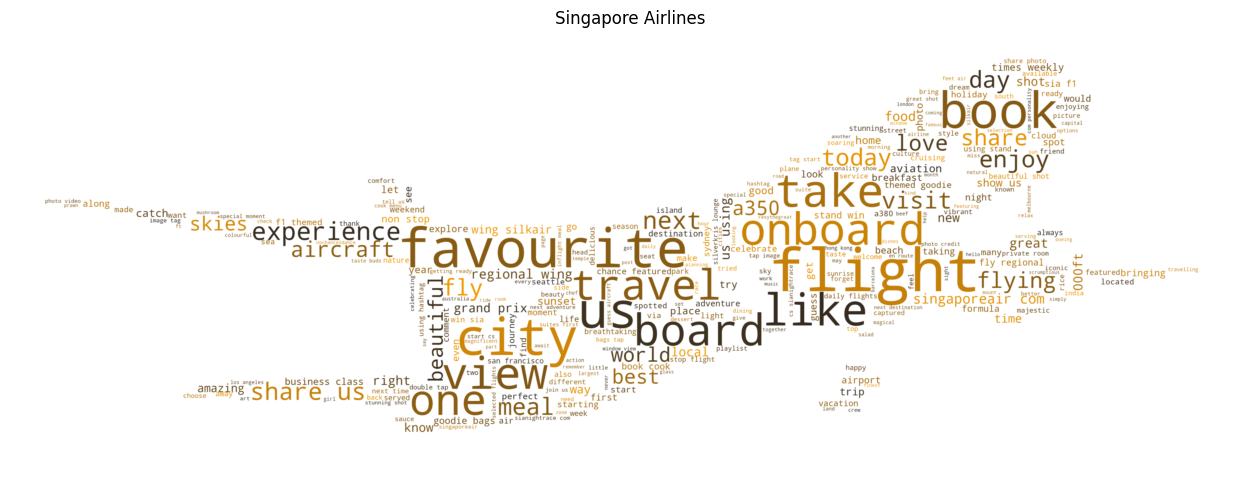

In [ ]:
# Generate word cloud for Singapore Airlines
generate_word_cloud(sin_text_cleaned.select("text_tokenized").collect(), "Singapore Airlines", plane_mask_path,
                    max_words=300,colormap=sns.dark_palette("#f29900",as_cmap=True),relative_scaling=0.6,
                    stopwords = ["Singapore","Airlines"])

### 3.4. Videos

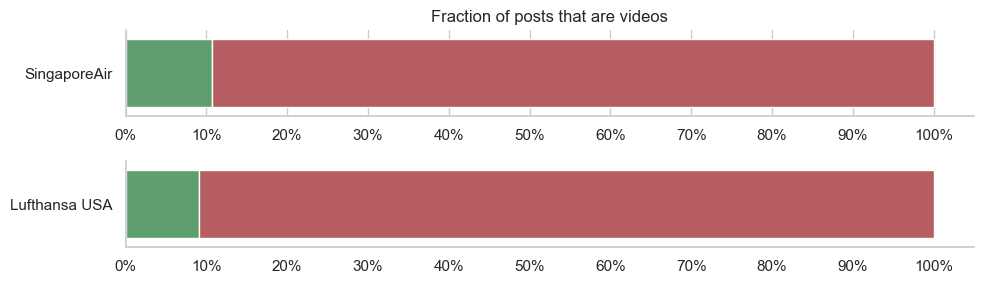

In [50]:
# Calculate the fraction of is_video for each company
sin_video_fraction = sin_posts_mature['is_video'].value_counts(normalize=True)
luf_video_fraction = luf_posts_mature['is_video'].value_counts(normalize=True)

# Plot the horizontal stacked bar plot for is_video by company
fig, axs = plt.subplots(2, 1, figsize=(10, 3))
palette = sns.color_palette("deep")
# Plot for SingaporeAir
sns.barplot(x=[sin_video_fraction[True] * 100], y=['SingaporeAir'], color=palette[2], label='Video', ax=axs[0],legend=False)
sns.barplot(x=[sin_video_fraction[False] * 100], y=['SingaporeAir'], left=sin_video_fraction[True] * 100,
            color=palette[3], label='Picture', ax=axs[0],legend=False)

# Plot for Lufthansa USA
sns.barplot(x=[luf_video_fraction[True] * 100], y=['Lufthansa USA'], color=palette[2], label='Video', ax=axs[1],legend=False)
sns.barplot(x=[luf_video_fraction[False] * 100], y=['Lufthansa USA'], left=luf_video_fraction[True] * 100,
            color=palette[3], label='Picture', ax=axs[1],legend=False)

# Set x-axis ticks every 10% and format as percentage
for ax in axs:
    ax.set_xticks(range(0, 101, 10))
    ax.set_xticklabels([f'{x}%' for x in range(0, 101, 10)])

# Set titles and legends
axs[0].set_title('Fraction of posts that are videos')
sns.despine()
plt.grid(False)
plt.tight_layout()
plt.show()

Main observations: 
- Both companies have a comparable fraction of video posts

Let's look at the post type over time

In [51]:
# create the function
def count_relative_media_types(df):
    media_types = (
        df
        .groupby("year_month")
        .agg(
            total_posts=("post_id", "count"),
            total_carousels=("is_carousel", "sum"),
            total_videos=("is_video", "sum")
        )
    ).reset_index()

    # Add new columns "picture_count" and "post_type" based on conditions
    media_types["total_pictures"] = media_types["total_posts"] - media_types["total_carousels"] - media_types["total_videos"]

    # Calculate relative amounts
    media_types["relative_pictures"] = media_types["total_pictures"] 
    media_types["relative_videos"] = media_types["total_videos"] 
    media_types["relative_carousels"] = media_types["total_carousels"]

    # Drop unnecessary columns
    media_types.drop(["total_posts", "total_carousels", "total_videos"], axis=1, inplace=True)

    media_types.set_index('year_month', inplace=True)
    column_order = ['relative_pictures','relative_carousels', 'relative_videos']
    media_types = media_types[column_order]
    
    return media_types

# Assuming sin_posts_pd and luf_posts_pd are your Pandas DataFrames
relative_media_types_sin = count_relative_media_types(sin_posts_mature)
relative_media_types_luf = count_relative_media_types(luf_posts_mature)

<Figure size 1000x600 with 0 Axes>

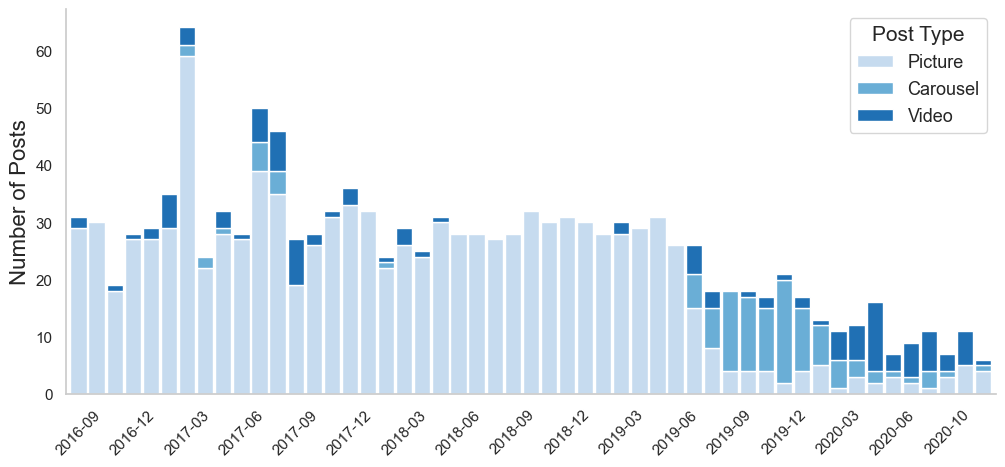

In [66]:
sns.set(rc={'figure.figsize': (12, 5)})
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
relative_media_types_luf.plot(kind='bar', stacked=True,color = sns.color_palette('Blues',3)[0:4], width=0.9)
plt.title('')
plt.ylabel('Number of Posts',fontsize=16)
legend_labels = ["Picture", "Carousel", "Video"]
plt.legend(title='Post Type', labels=legend_labels, loc='upper right',title_fontsize = 15, fontsize=13)
plt.xlabel("")
plt.xticks(rotation=45) 
plt.xticks(range(0, len(relative_media_types_sin.index), 3), relative_media_types_sin.index[::3])
sns.despine()
plt.grid(False)
plt.show()

<Figure size 1000x600 with 0 Axes>

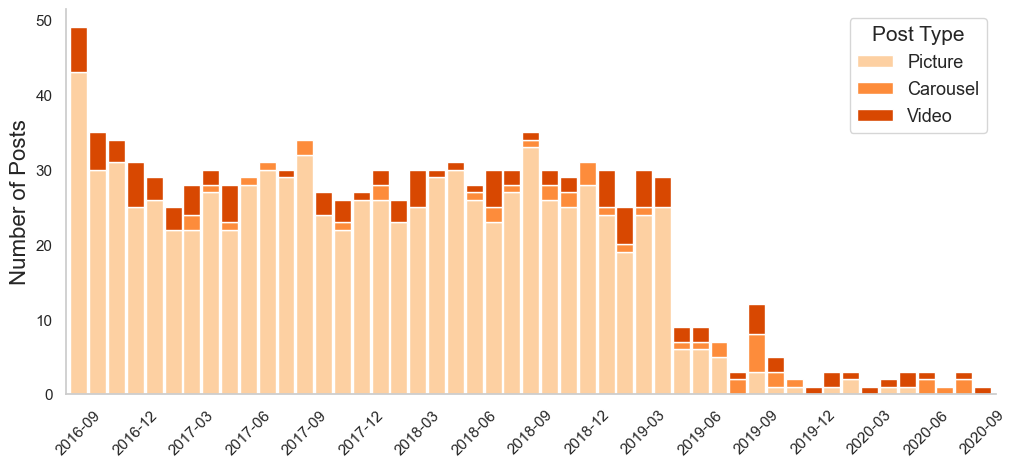

In [68]:
sns.set(rc={'figure.figsize': (12, 5)})
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
relative_media_types_sin.plot(kind='bar', stacked=True,color = sns.color_palette('Oranges',3)[0:4], width=0.9)
plt.title('')
plt.ylabel('Number of Posts',fontsize=16)
legend_labels = ["Picture", "Carousel", "Video"]
plt.legend(title='Post Type', labels=legend_labels, loc='upper right',title_fontsize = 15, fontsize=13)
plt.xlabel("")
plt.xticks(rotation=45) 
plt.xticks(range(0, len(relative_media_types_luf.index), 3), relative_media_types_luf.index[::3])
sns.despine()
plt.grid(False)
plt.show()

Observations:
- Lufthansa really started experimenting with carousel and afterwards videos starting 2019
- SingaporeAir has been using videos more consistently over time, and has focused less on carousels

### 4 Comments

#### 4.1. General metrics

In [7]:
# get all the names of the comment files in our Data repository
comment_names_sin = [obs for obs in os.listdir(data_dir_sin) if "_comments.json" in obs]
comment_names_luf = [obs for obs in os.listdir(data_dir_luf) if "_comments.json" in obs]

# get all the paths of the comment files
comment_paths_sin = [os.path.join(data_dir_sin, obs) for obs in comment_names_sin]
comment_paths_luf = [os.path.join(data_dir_luf, obs) for obs in comment_names_luf]

In [8]:
# import the comments in a single dataframe
comments_df_sin = spark.read.json(comment_paths_sin, multiLine=True)

# add file path as a new column
comments_df_sin = comments_df_sin.withColumn("file_path", F.input_file_name())

# extract id from file path and add as new column
comments_df_sin = comments_df_sin.withColumn("post_id", F.regexp_extract(str=comments_df_sin.file_path, pattern="(singaporeair/)(.*)(_comments.json)", idx=2))

# drop file path column
comments_df_sin = comments_df_sin.drop("file_path")


# import the comments in a single dataframe
comments_df_luf = spark.read.json(comment_paths_luf, multiLine=True)

# add file path as a new column
comments_df_luf = comments_df_luf.withColumn("file_path", F.input_file_name())

# extract id from file path and add as new column
comments_df_luf = comments_df_luf.withColumn("post_id", F.regexp_extract(str=comments_df_luf.file_path, pattern="(lufthansa_usa/)(.*)(_comments.json)", idx=2))

# drop file path column
comments_df_luf = comments_df_luf.drop("file_path")

In [9]:
comments_df_luf.printSchema()

root
 |-- answers: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- created_at: long (nullable = true)
 |    |    |-- id: long (nullable = true)
 |    |    |-- likes_count: long (nullable = true)
 |    |    |-- owner: struct (nullable = true)
 |    |    |    |-- id: string (nullable = true)
 |    |    |    |-- is_verified: boolean (nullable = true)
 |    |    |    |-- profile_pic_url: string (nullable = true)
 |    |    |    |-- username: string (nullable = true)
 |    |    |-- text: string (nullable = true)
 |-- created_at: long (nullable = true)
 |-- id: long (nullable = true)
 |-- likes_count: long (nullable = true)
 |-- owner: struct (nullable = true)
 |    |-- id: string (nullable = true)
 |    |-- is_verified: boolean (nullable = true)
 |    |-- profile_pic_url: string (nullable = true)
 |    |-- username: string (nullable = true)
 |-- text: string (nullable = true)
 |-- post_id: string (nullable = false)



In [11]:
# Function to calculate metrics
def calculate_metrics(df, name):
    total_comments_count = df.count()
    
    average_likes_df = df.select("likes_count").agg(F.avg("likes_count").alias("average_likes"))
    influencer_comments_count_df = df.filter("owner.is_verified == true").count()
    distinct_influencers_df = df.filter("owner.is_verified == true").select("owner.id").distinct().count()
    average_text_length_df = df.select(F.length("text").alias("text_length")).agg(F.avg("text_length").alias("average_text_length"))
    proportion_verified_comments = influencer_comments_count_df / total_comments_count
    metrics = {
        "Dataset": name,
        "Average Likes per Comment": average_likes_df.first()["average_likes"],
        "Count of Verified Comments": influencer_comments_count_df,
        "Proportion of Verified Comments": proportion_verified_comments,
        "Count of Distinct Verified User IDs": distinct_influencers_df,
        "Average Text Length": average_text_length_df.first()["average_text_length"]
    }

    return metrics

# Calculate metrics for both DataFrames
luf_metrics = calculate_metrics(comments_df_luf, "LufthansaUSA")
sin_metrics = calculate_metrics(comments_df_sin, "SingaporeAir")

# Convert metrics to DataFrames for easier plotting
metrics_df = spark.createDataFrame([luf_metrics, sin_metrics]).toPandas()

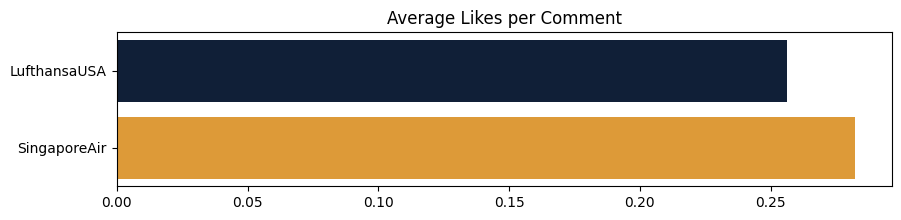

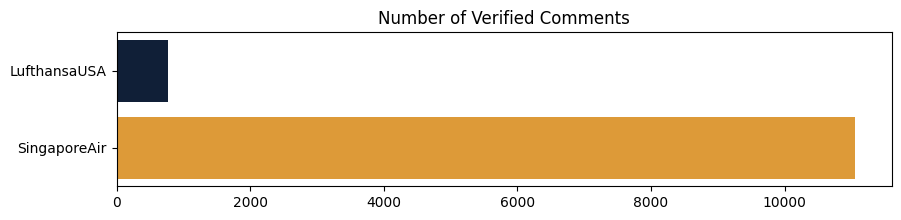

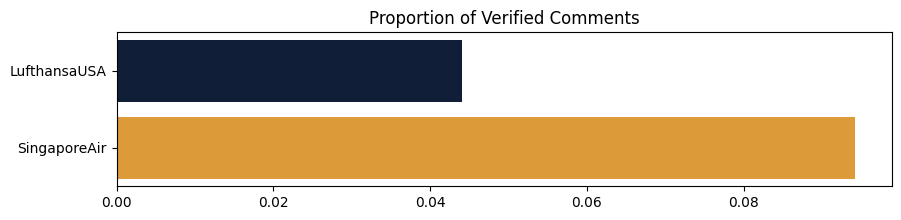

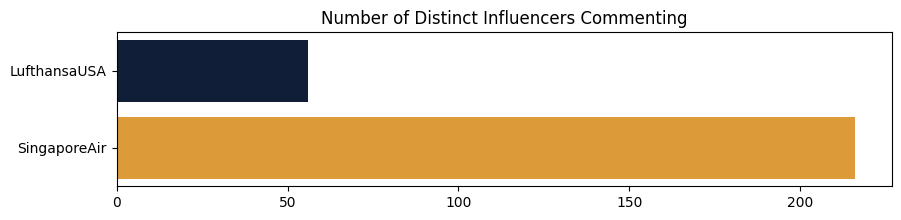

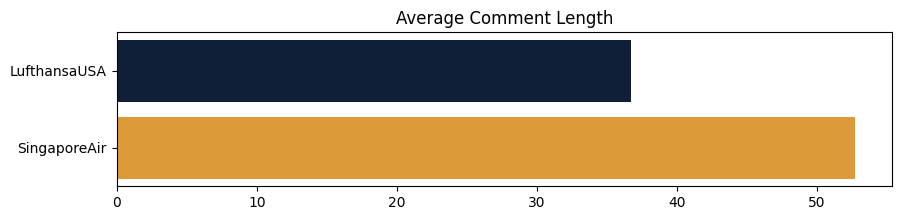

In [12]:
def plot_metrics(x, y, title):
    plt.figure(figsize=(10, 2))
    sns.barplot(x=x, y=y, hue="Dataset", data=metrics_df, palette={sin_color, luf_color}, legend=False)
    plt.title(title)
    plt.xlabel(None)
    plt.ylabel(None)
    plt.show()

# Example usage:
plot_metrics("Average Likes per Comment", "Dataset", "Average Likes per Comment")
plot_metrics("Count of Verified Comments", "Dataset", "Number of Verified Comments")
plot_metrics("Proportion of Verified Comments", "Dataset", "Proportion of Verified Comments")
plot_metrics("Count of Distinct Verified User IDs", "Dataset", "Number of Distinct Influencers Commenting")
plot_metrics("Average Text Length", "Dataset", "Average Comment Length")

#### 4.2. Engagement Valence in the comments

In [ ]:
## Define the function to extract the sentiment
def get_sentiment(sentence):
    # initialize sentiment analyzer
    sid_obj = SentimentIntensityAnalyzer()
    # get sentiment dict
    sentiment_dict = sid_obj.polarity_scores(sentence)
    # get compound sentiment score
    pos_sentiment = sentiment_dict["compound"]
    # return compound sentiment score
    return(pos_sentiment)

# convert to udf
get_sentiment_udf = F.udf(get_sentiment, DoubleType())

In [ ]:
# define data dir for brand owned posts 
sign_dir = "../data/singaporeair/"
luf_dir = "../data/lufthansa_usa/"

# get all the names of the comment files in our Data repository
sign_comment_names = [obs for obs in os.listdir(sign_dir) if "_comments.json" in obs]
luf_comment_names = [obs for obs in os.listdir(luf_dir) if "_comments.json" in obs]

# get all the paths of the comment files
sign_comment_paths = [os.path.join(sign_dir, obs) for obs in sign_comment_names]
luf_comment_paths = [os.path.join(luf_dir, obs) for obs in luf_comment_names]

In [ ]:
# import the comments in a single dataframe
sign_comments_df = spark.read.json(sign_comment_paths, multiLine=True)

# add file path as a new column
sign_comments_df = sign_comments_df.withColumn("file_path", F.input_file_name())

# extract id from file path and add as new column
sign_comments_df = sign_comments_df.withColumn("post_id", F.regexp_extract(str=sign_comments_df.file_path, pattern="(singaporeair/)(.*)(_comments.json)", idx=2))

# drop file path column
sign_comments_df = sign_comments_df.drop("file_path").cache()

# import the comments in a single dataframe
luf_comments_df = spark.read.json(luf_comment_paths, multiLine=True)

# add file path as a new column
luf_comments_df = luf_comments_df.withColumn("file_path", F.input_file_name())

# extract id from file path and add as new column
luf_comments_df = luf_comments_df.withColumn("post_id", F.regexp_extract(str=luf_comments_df.file_path, pattern="(lufthansa_usa/)(.*)(_comments.json)", idx=2))

# drop file path column
luf_comments_df = luf_comments_df.drop("file_path").cache()

In [ ]:
luf_comments_df_eng = luf_comments_df.withColumn("sentiment", get_sentiment_udf(F.col("text"))).cache()

sign_comments_df_eng = sign_comments_df.withColumn("sentiment", get_sentiment_udf(F.col("text"))).cache()

In [ ]:
luf_comments_df_eng.show()

+-------+----------+-----------------+-----------+--------------------+--------------------+--------------------+---------+
|answers|created_at|               id|likes_count|               owner|                text|             post_id|sentiment|
+-------+----------+-----------------+-----------+--------------------+--------------------+--------------------+---------+
|     []|1569434776|17916855694344548|          0|{333051985, false...|Dejan varados a l...|2019-09-23_11-00-...|      0.0|
|     []|1569415556|17925403156326146|          0|{427340901, false...|Denle la mamaa a ...|2019-09-23_11-00-...|      0.0|
|     []|1569413179|17864841247492225|          0|{1563143361, fals...|No sirve que mal ...|2019-09-23_11-00-...|   -0.296|
|     []|1569412020|17928514567319380|          0|{4156635818, fals...|     Inrresponsables|2019-09-23_11-00-...|      0.0|
|     []|1569408269|18103436887027822|          0|{1176477871, fals...|Irresponsablessss...|2019-09-23_11-00-...|      0.0|
|     []

In [ ]:
valence_engagement_luf = luf_comments_df_eng.withColumn(
    "post_id_modified", 
    F.expr("substring(post_id, 1, length(post_id) - 4)"))\
    .withColumn("post_date", F.to_timestamp("post_id_modified", "yyyy-MM-dd_HH-mm-ss"))\
    .withColumn("year", F.year("post_date"))\
    .withColumn("month", F.month("post_date"))\
    .withColumn("year_month", F.concat_ws("-", F.col("year"), F.format_string("%02d", "month")))\
    .groupBy("year_month")\
    .agg(F.avg(F.when(F.col("sentiment") != 0, F.col("sentiment"))).alias("average_sentiment")).cache()

valence_engagement_luf.show()

+----------+--------------------+
|year_month|   average_sentiment|
+----------+--------------------+
|   2019-10|  0.5022703488372092|
|   2020-02| 0.48964771241830063|
|   2019-11|    0.50471990521327|
|   2020-05| 0.32937481481481484|
|   2018-02| 0.42952723880597016|
|   2019-07|  0.4846122448979593|
|   2018-08|  0.6005893280632412|
|   2019-05|  0.5105173184357542|
|   2019-08|  0.4581133333333333|
|   2019-09|0.026929262672810754|
|   2020-03| 0.35161832061068704|
|   2020-01|  0.4299085201793723|
|   2019-06|  0.5014562962962963|
|   2019-12|  0.5220930591259637|
|   2020-06| 0.39289999999999997|
|   2018-10|  0.5241524064171122|
|   2018-06|   0.557675172413793|
|   2018-03|  0.5672766233766233|
|   2020-07| 0.20252622950819674|
|   2017-12|  0.6467989583333335|
+----------+--------------------+
only showing top 20 rows



In [ ]:
valence_engagement_sign = sign_comments_df_eng.withColumn(
    "post_id_modified", 
    F.expr("substring(post_id, 1, length(post_id) - 4)"))\
    .withColumn("post_date", F.to_timestamp("post_id_modified", "yyyy-MM-dd_HH-mm-ss"))\
    .withColumn("year", F.year("post_date"))\
    .withColumn("month", F.month("post_date"))\
    .withColumn("year_month", F.concat_ws("-", F.col("year"), F.format_string("%02d", "month")))\
    .groupBy("year_month")\
    .agg(F.avg(F.when(F.col("sentiment") != 0, F.col("sentiment"))).alias("average_sentiment")).cache()

valence_engagement_sign.show()

+----------+-------------------+
|year_month|  average_sentiment|
+----------+-------------------+
|   2020-06|0.40010067114093967|
|   2020-02|0.23397428571428566|
|   2017-10| 0.5894905063291137|
|   2019-03| 0.5437278227524498|
|   2017-11| 0.5563301196340604|
|   2017-03| 0.5343004850444623|
|   2017-06| 0.5347787701317714|
|   2016-10| 0.5084948892674617|
|   2018-05| 0.5404639085894404|
|   2018-08| 0.5259518333333333|
|   2019-05| 0.5483270748299319|
|   2019-01|  0.532744333333333|
|   2019-09|0.49024228295819916|
|   2020-03|0.14586124999999997|
|   2017-12| 0.5494716553287982|
|   2019-04|  0.559114087403599|
|   2016-06| 0.5291389621811784|
|   2018-01| 0.5611246693121692|
|   2016-08| 0.6666888217522661|
|   2020-04|0.34732619926199254|
+----------+-------------------+
only showing top 20 rows



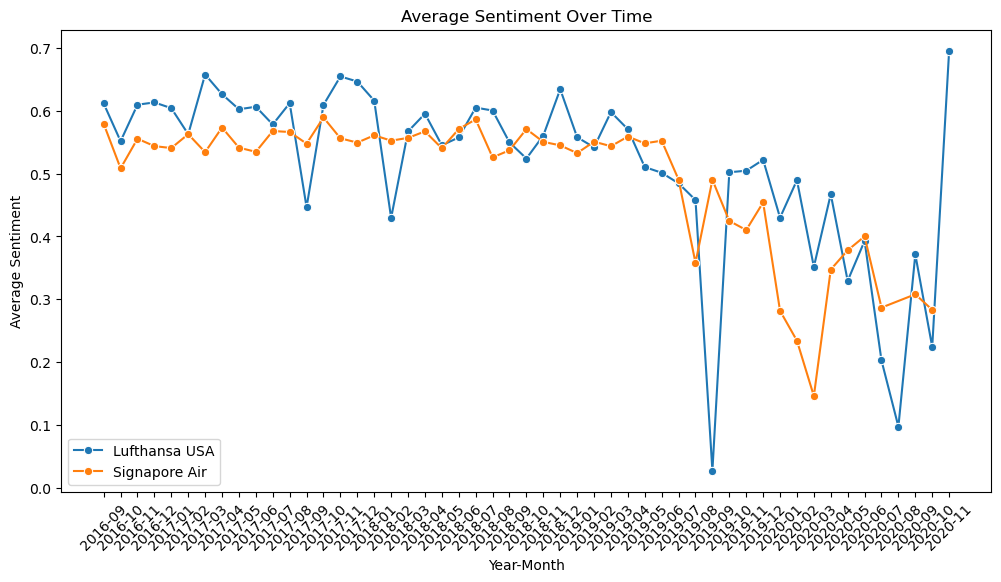

In [ ]:
result_df_luf = result_df.filter("year_month >= '2016-09'").sort("year_month")
result_df_sign = result_df_sign.filter("year_month >= '2016-09'").sort("year_month")

# Converting Spark DataFrame to Pandas DataFrame
pandas_df_luf = result_df_luf.toPandas()

# Converting Spark DataFrame to Pandas DataFrame
pandas_df_sign = result_df_sign.toPandas()

# Visualization using Seaborn on the same figure
plt.figure(figsize=(12, 6))
sns.lineplot(x="year_month", y="average_sentiment", data=pandas_df_luf, marker='o', label='Lufthansa USA')
sns.lineplot(x="year_month", y="average_sentiment", data=pandas_df_sign, marker='o', label='Signapore Air')
plt.title('Average Sentiment Over Time')
plt.xlabel('Year-Month')
plt.ylabel('Average Sentiment')
plt.xticks(rotation=45)
plt.legend()  # Add legend to distinguish between lines
plt.show()
